In [1]:
from hydra import initialize_config_dir, compose
from gaze_av_aloha.configs import Config
from omegaconf import OmegaConf
import gaze_av_aloha
from gaze_av_aloha.policies.gaze_policy.gaze_policy import GazePolicy
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset, AVAlohaDatasetMeta
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Path to your config directory (adjust as needed)
config_dir = os.path.abspath("../configs")

overrides = [
    "policy=foveated_vit_policy",
    "policy.visualize=False",
]

with initialize_config_dir(config_dir=config_dir, job_name="my_app"):
    cfg: Config = compose(config_name="default", overrides=overrides)


/tmp/ipykernel_1791561/2156843835.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=config_dir, job_name="my_app"):


In [9]:
dataset_meta = AVAlohaDatasetMeta(repo_id=cfg.task.dataset_repo_id, root=cfg.task.dataset_root)
policy = GazePolicy(cfg.policy, cfg.task, dataset_meta.stats)
policy.eval()

GazePolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_images_zed_cam_left): ParameterDict(
        (mean): Parameter containing: [torch.FloatTensor of size 3x1x1]
        (std): Parameter containing: [torch.FloatTensor of size 3x1x1]
    )
    (buffer_action): ParameterDict(
        (max): Parameter containing: [torch.FloatTensor of size 21]
        (min): Parameter containing: [torch.FloatTensor of size 21]
    )
    (buffer_observation_state): ParameterDict(
        (max): Parameter containing: [torch.FloatTensor of size 21]
        (min): Parameter containing: [torch.FloatTensor of size 21]
    )
  )
  (unnormalize_outputs): Unnormalize(
    (buffer_action): ParameterDict(
        (max): Parameter containing: [torch.FloatTensor of size 21]
        (min): Parameter containing: [torch.FloatTensor of size 21]
    )
  )
  (flow): FlowModel(
    (backbone): FoveatedViT(
      (tokenizer): FoveatedImageTokenizer(
        (foveator): BatchedFoveator()
        (resize): Resiz

In [3]:
dataset = AVAlohaDataset(
    repo_id=cfg.task.dataset_repo_id, 
    root=cfg.task.dataset_root,
    episodes=cfg.task.dataset_episodes,
    delta_timestamps=policy.get_delta_timestamps(),
)

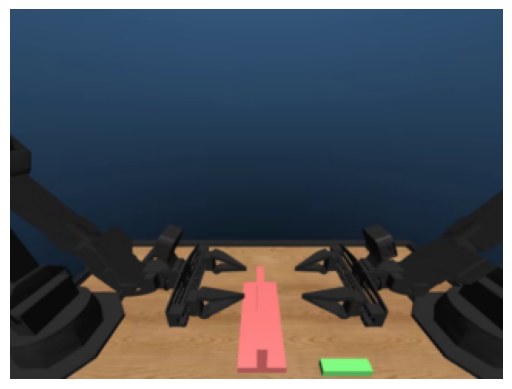

In [4]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
batch = next(iter(dataloader))

plt.imshow(batch[cfg.task.image_keys[0]][0,0].permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

In [ ]:
from fvcore.nn import FlopCountAnalysis
import torch

# Example model and input
x = torch.randn(1, policy.flow.backbone.get_num_tokens(*cfg.policy.input_shape), policy.flow.backbone.embed_dim)
model = policy.flow.backbone.backbone
flops = FlopCountAnalysis(model, x)
print(f"FLOPs: {flops.total()}")  # total in float
print(f"GFLOPs: {flops.total() / 1e9:.2f}")

# calculate inference time of the model
import time
start_time = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = model(x)
end_time = time.time()
inference_time = (end_time - start_time) / 100  # average over 100 iterations
print(f"Inference time: {inference_time:.6f} seconds")


Unsupported operator aten::add encountered 25 time(s)
Unsupported operator aten::div encountered 12 time(s)
Unsupported operator aten::unflatten encountered 12 time(s)
Unsupported operator aten::mul encountered 60 time(s)
Unsupported operator aten::softmax encountered 12 time(s)
Unsupported operator aten::gelu encountered 12 time(s)
Unsupported operator aten::sub encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
blocks.0.attn.out_proj, blocks.0.drop_path, blocks.1.attn.out_proj, blocks.1.drop_path, blocks.10.attn.out_proj, blocks.10.drop_path, blocks.11.attn.out_proj, blocks.11.drop_path, blocks.2.attn.out_proj, blocks.2.drop_path, blocks.3.attn.out_proj, blocks.3.drop_path, blocks.4.attn.out_proj

FLOPs: 1805488128
GFLOPs: 1.81
Inference time: 0.004150 seconds
